In [1]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import re
import unicodedata
from wordcloud import WordCloud
%matplotlib inline

In [2]:
# Load and view data
reviews_df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
reviews_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
reviews_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
reviews_df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

There are an equal number of positive and negative reviews therefore the target variable is not highly imbalanced.

In [5]:
reviews_df['review'].isna().value_counts()

False    50000
Name: review, dtype: int64

There are 50,000 reviews with text to be cleaned.

In [6]:
# Take a look at a few reviews so I know how to properly clean the text
print(reviews_df['review'][0])
print(reviews_df['review'][25000])
print(reviews_df['review'][49999])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

To clean this text I will perform standard cleaning procedures such as removing accented characters, stop words, and special characters. I will also lowercase all text and expand contractions. Below the contraction map, I have created all of the functions to clean the text and below that all of the functions are combined into one called 'clean_reviews'.

In [7]:
# dictionary containing all contractions
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [8]:
def remove_stopwords(review):
    
    stop_words = stopwords.words('english')
    
    filtered_text = []
    
    word_tokens = word_tokenize(review)
  
    for word in word_tokens: 
        if word not in stop_words: 
            filtered_text.append(word)
            
    return filtered_text



def expand_contractions(review, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower()) 
        
        expanded_contraction = first_char + expanded_contraction[1:]
        
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, review)
    
    expanded_text = re.sub("'", "", expanded_text)
    
    return expanded_text



def remove_accents(review):
    
    review = unicodedata.normalize('NFKD', review).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    return review


    
def lower_text(review):
    
    review = review.lower()
    
    return review

    
    
def remove_specialchars_and_digits(review):
    
    review = re.sub(r'[^a-zA-z\s]', '', review)
    
    return review

    
    
def lemmatize_text(review):
    
    lemmatized_text = []
  
    lemmatizer = WordNetLemmatizer()
    
    word_tokens = word_tokenize(review)
    
    lemmatized_text = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])
    
    return lemmatized_text

In [9]:
# takes text as an input and returns the cleaned text
def clean_reviews(reviews, remove_digits=True):
    
    clean_reviews = []
    
    for review in reviews:
        
        # remove extra newlines
        review = re.sub(r'[\r|\n|\r\n]+', ' ',review)
        
        # remove line breaks in text
        review = re.sub('<br />', ' ', review)
        
        # remove quotations
        review = re.sub('"', '', review)
        
        # remove extra whitespace
        review = re.sub(' +', ' ', review)
        
        review = remove_accents(review)
    
        review = expand_contractions(review)
        
        review = lower_text(review)
        
        review = lemmatize_text(review)
        
        review = remove_specialchars_and_digits(review)
        
        review = remove_stopwords(review)
        
        clean_reviews.append(review)
    
    return clean_reviews


In [10]:
# call function on reviews in DataFrame to clean them
reviews_df['clean_reviews'] = clean_reviews(reviews_df['review'])

In [11]:
reviews_df.head()

,review,sentiment,clean_reviews
0,One of the other reviewers has mentioned that ...,positive,"[one, reviewer, ha, mentioned, watching, oz, e..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wa, wonderful, way, spend, time, hot..."
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, matteis, love, time, money, visually,..."


In [12]:
# modify clean text to be a clean string
reviews_df['clean_reviews_str'] = [' '.join(map(str,i)) for i in reviews_df['clean_reviews']]
reviews_df.head()

,review,sentiment,clean_reviews,clean_reviews_str
0,One of the other reviewers has mentioned that ...,positive,"[one, reviewer, ha, mentioned, watching, oz, e...",one reviewer ha mentioned watching oz episode ...
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn...",wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wa, wonderful, way, spend, time, hot...",thought wa wonderful way spend time hot summer...
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, think, ...",basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, matteis, love, time, money, visually,...",petter matteis love time money visually stunni...


## Now that the reviews have been cleaned the exploratory portion of the data begins below. <br><br> For my exploratory data analysis I want to visualize word clouds, frequency of common words, and length of reviews as word count and character count.

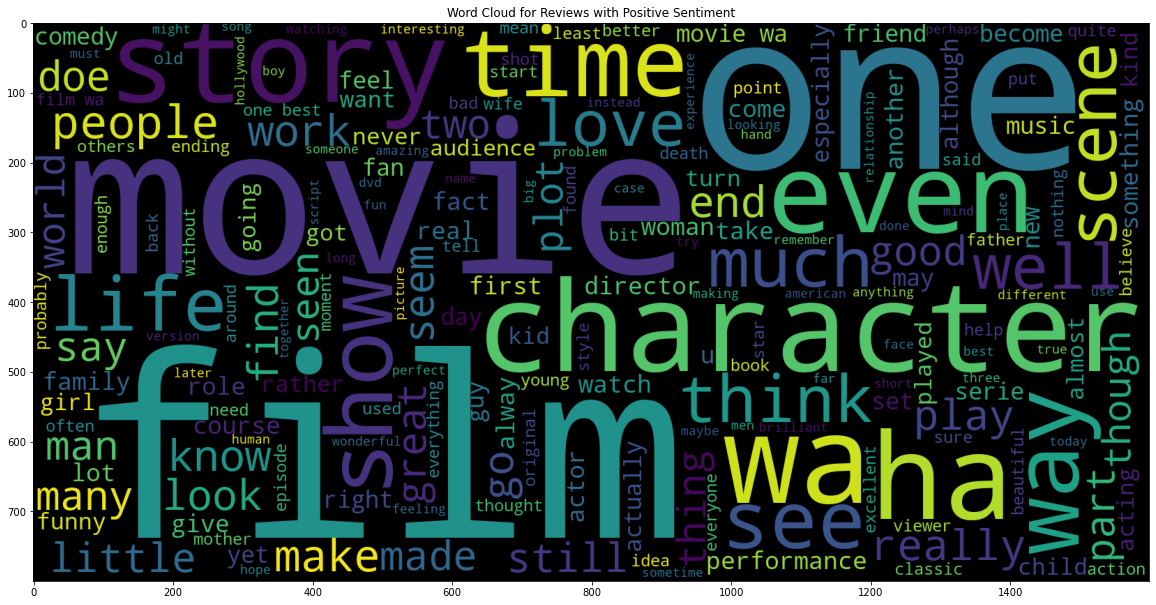

In [13]:
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600, height = 800).generate(" ".join(reviews_df[reviews_df['sentiment'] == 'positive']['clean_reviews_str']))
plt.title('Word Cloud for Reviews with Positive Sentiment')
plt.imshow(wc);

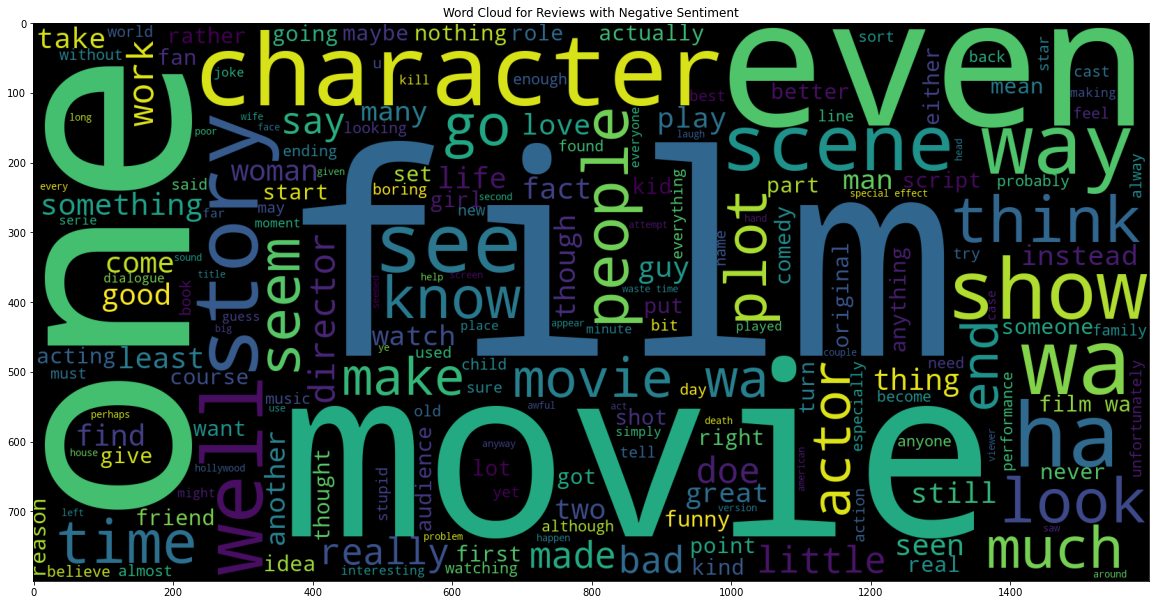

In [14]:
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600, height = 800).generate(" ".join(reviews_df[reviews_df['sentiment'] == 'negative']['clean_reviews_str']))
plt.title('Word Cloud for Reviews with Negative Sentiment')
plt.imshow(wc);

### From the word clouds it can be seen there are a few obvious words that are used most in both positive and negative reviews. However if you look closely there are certain words that seem appropriate for positive and negative reviews. <br><br> Below I have visualized the most common words throughout all of the reviews and the results align with the word clouds created above.

In [15]:
# combine all of the words from all of the reviews into one list
reviews = reviews_df['clean_reviews']
allreviews = []
for review in reviews:
    allreviews += review

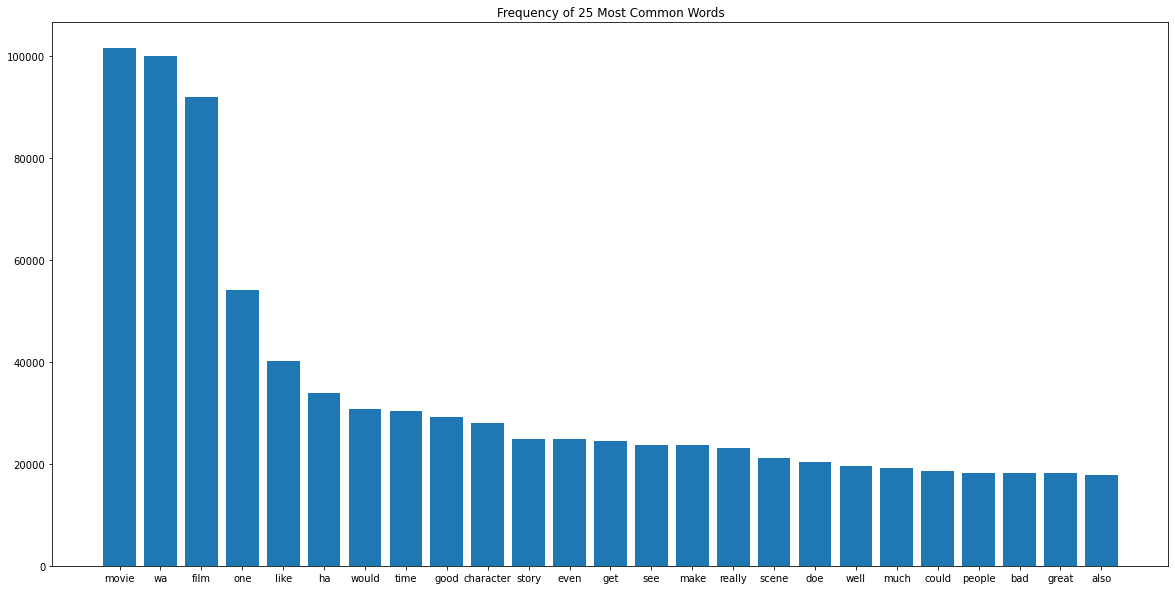

In [16]:
mostcommon_words = FreqDist(allreviews).most_common(25)
x, y = zip(*mostcommon_words)

plt.figure(figsize=(20,10))
plt.title('Frequency of 25 Most Common Words')
plt.bar(x, y);

### I will now visualize the word counts and character length of the reviews.

In [17]:
# add word count and length of reviews to dataframe
reviews_df['review_word_count'] = reviews_df['clean_reviews'].apply(lambda x: len(x))
reviews_df['review_length'] = reviews_df['clean_reviews_str'].astype(str).apply(len)
reviews_df.head()

,review,sentiment,clean_reviews,clean_reviews_str,review_word_count,review_length
0,One of the other reviewers has mentioned that ...,positive,"[one, reviewer, ha, mentioned, watching, oz, e...",one reviewer ha mentioned watching oz episode ...,168,1098
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn...",wonderful little production filming technique ...,86,646
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wa, wonderful, way, spend, time, hot...",thought wa wonderful way spend time hot summer...,88,583
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, think, ...",basically family little boy jake think zombie ...,64,425
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, matteis, love, time, money, visually,...",petter matteis love time money visually stunni...,126,846


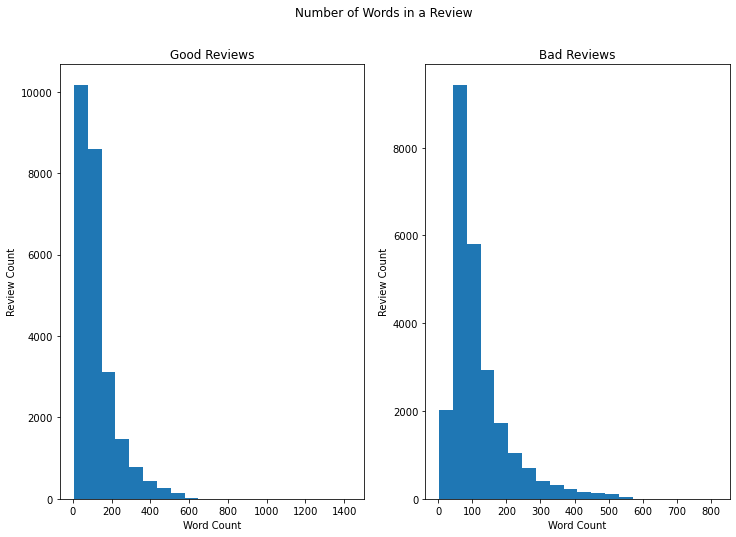

In [18]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (12,8))

ax1.hist(reviews_df[reviews_df['sentiment'] == 'positive']['review_word_count'], bins=20)
ax1.set_title('Good Reviews')
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Review Count')

ax2.hist(reviews_df[reviews_df['sentiment'] == 'negative']['review_word_count'], bins=20)
ax2.set_title('Bad Reviews')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Review Count')

fig.suptitle('Number of Words in a Review')
plt.show()

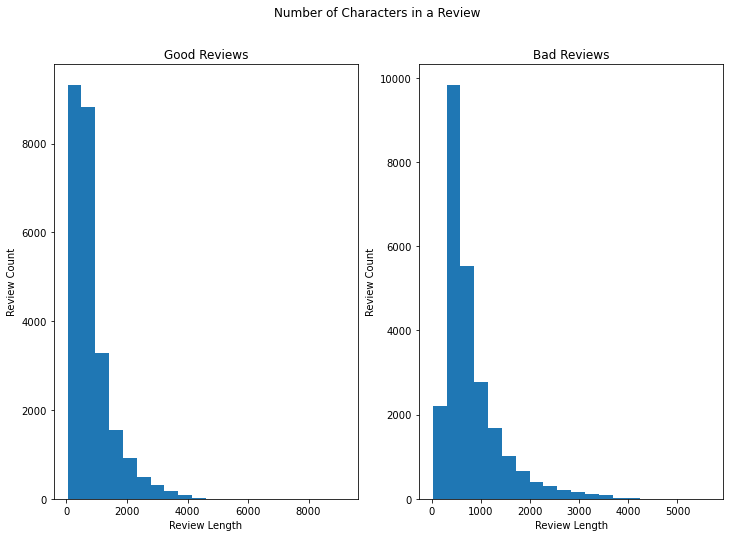

In [19]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (12,8))

ax1.hist(reviews_df[reviews_df['sentiment'] == 'positive']['review_length'], bins=20)
ax1.set_title('Good Reviews')
ax1.set_xlabel('Review Length')
ax1.set_ylabel('Review Count')

ax2.hist(reviews_df[reviews_df['sentiment'] == 'negative']['review_length'], bins=20)
ax2.set_title('Bad Reviews')
ax2.set_xlabel('Review Length')
ax2.set_ylabel('Review Count')

fig.suptitle('Number of Characters in a Review')
plt.show()

### When looking at the bar plots above, for the reviews word and character length, it can be seen that really short reviews tend to be more positive than negative.

In [20]:
# write cleaned reviews to a csv so it can be used in the next steps (preprocessing and modeling)
reviews_df.to_csv('imdb_reviews_cleaned.csv', index = False)